# Exact simulation with Qiskit primitives

The reference primitives in Qiskit perform local statevector simulations. These simulations do not support
modeling device noise, but are useful for quickly prototyping algorithms before looking into more advanced simulation
techniques (using Qiskit Aer) or running on real devices (Qiskit Runtime primitives).

The `Estimator` primitive can compute expectation values of circuits, and the `Sampler` primitive can sample
from output distributions of circuits.

The following sections show how to use the reference primitives to run your workflow locally.

## Use the reference `Estimator`

There are two reference implementations of `Estimator` in `qiskit.primitives` that run on a local statevector
simulators: the [`StatevectorEstimator`](../api/qiskit/qiskit.primitives.StatevectorEstimator) class and the
[`Estimator`](../api/qiskit/qiskit.primitives.Estimator) class. The [`StatevectorEstimator`](../api/qiskit/qiskit.primitives.StatevectorEstimator)
implements the new Estimator V2 interface introduced in the Qiskit SDK 1.0, and offers additional input vectorization
features in comparison with the [`Estimator`](../api/qiskit/qiskit.primitives.Estimator) class, which implements the
legacy Estimator V1 interface. Both can take circuits, observables, and parameters as inputs and return the locally
computed expectation values.

The following code prepares the inputs that will be used in the examples that follow. The expected input type for the
observables is [`qiskit.quantum_info.SparsePauliOp`](../api/qiskit/qiskit.quantum_info.SparsePauliOp). Note that
the circuit in the example is parametrized, but you can also run the Estimator on non-parametrized circuits.

<Admonition type="note">
  Any circuit passed to an Estimator must **not** include any **measurements**.
</Admonition>

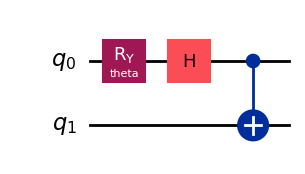

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# circuit for which you want to obtain the expected value
qc = QuantumCircuit(2)
qc.ry(Parameter('theta'), 0)
qc.h(0)
qc.cx(0,1)
qc.draw("mpl", style="iqp")

In [2]:
# observable(s) whose expected values you want to compute
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

# value(s) for the circuit parameter(s)
import numpy as np
parameter_values = [[0], [np.pi/6], [np.pi/2]]

### Initialize an Estimator

To use the Estimator V2 implementation, follow the instructions to instantiate a
[`qiskit.primitives.StatevectorEstimator`](../api/qiskit/qiskit.primitives.StatevectorEstimator). If you want to maintain
your pre-existing workflow using an Estimator V1 implementation, you can also use the
[`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) class.

<Tabs>
  <TabItem value="EstimatorV2" label="StatevectorEstimator (V2)">
    Instantiate a [`qiskit.primitives.StatevectorEstimator`](../api/qiskit/qiskit.primitives.StatevectorEstimator).

```python
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
```
  </TabItem>

  <TabItem value="EstimatorV1" label="Estimator (V1)">
    Instantiate a [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator).

```python
from qiskit.primitives import Estimator
estimator = Estimator()
```
  </TabItem>
</Tabs>

### Run and get results

This example only uses one circuit (of type [`QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit)) and one
observable.


<Tabs>
  <TabItem value="EstimatorV2" label="StatevectorEstimator (V2)">
    Run the estimation by calling the [`StatevectorEstimator.run`](../api/qiskit/qiskit.primitives.StatevectorEstimator#run)
    method, which returns an instance of a [PrimitiveJob](/api/qiskit/qiskit.primitives.PrimitiveJob) object. You can get the results from the
    job (as a [`qiskit.primitives.PrimitiveResult`](../api/qiskit/qiskit.primitives.PrimitiveResult) object)
    with the [`qiskit.primitives.PrimitiveResult.primitiveresult`](../api/qiskit/qiskit.primitives.PrimitiveResult#primitiveresult) method.

```python
job = estimator.run([(qc, observable, parameter_values)])
result = job.result()
print(f" > Result class: {type(result)}")
```
```text
 > Result class: <class 'qiskit.primitives.containers.primitive_result.PrimitiveResult'>
```
  </TabItem>
  <TabItem value="EstimatorV1" label="Estimator (V1)">
    Run the estimation by calling the [`Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run) method,
    which returns an instance of [`qiskit.providers.JobV1`](../api/qiskit/qiskit.providers.JobV1). You can get the results from the
    job (as an [`EstimatorResult`](../api/qiskit/qiskit.primitives.EstimatorResult) object)
    with the [`JobV1.result`](../api/qiskit/qiskit.providers.JobV1#result) method.

```python
job = estimator.run([qc]*3, [observable]*3, parameter_values)
result = job.result()
print(f" > Result class: {type(result)}")
```
```text
 > Result class: <class 'qiskit.primitives.base.estimator_result.EstimatorResult'>
```
  </TabItem>
</Tabs>

#### Get the expected value from the result

<Tabs>
  <TabItem value="EstimatorV2" label="StatevectorEstimator (V2)">

      The primitives V2 result outputs an array of [`PubResult`s](/api/qiskit/qiskit.primitives.PubResult#pubresult), where each item of the array is a `PubResult` object
      that contains in its data the array of evaluations corresponding to every circuit-observable combination in the PUB.
      To retrieve the expectation values and metadata for the first
      (and in this case, only) circuit evaluation, we must access the evaluation [`data`](/api/qiskit/qiskit.primitives.PubResult#data) for PUB 0:

```python
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")
```
```text
 > Expectation value: [4.         3.73205081 2.        ]
 > Metadata: {'precision': 0.0}
```
  </TabItem>
  <TabItem value="EstimatorV1" label="Estimator (V1)">

      The primitives V1 result stores an array of values that can be accessed through the attribute
      [`EstimatorResult.values`](../api/qiskit/qiskit.primitives.EstimatorResult#values), where the`i`<sup>th</sup>
      element is the expectation value corresponding to the `i`<sup>th</sup> circuit and `i`<sup>th</sup> observable.
      To see the values for the first (and in this case, only) circuit evaluation, we must access the first item of the array.

```python
print(f" > Expectation value: {result.values[0]}")
print(f" > Metadata: {result.metadata}")
```

```text
 > Expectation value: 3.999999999999999
 > Metadata: [{}, {}, {}]
```
  </TabItem>
</Tabs>

### Set Estimator run options

By default, the reference Estimator performs an exact statevector calculation based on the
[`quantum_info.Statevector`](../api/qiskit/qiskit.quantum_info.Statevector) class.
However, this can be modified to introduce the effect of the sampling overhead (also known as "shot noise").

With the introduction of the new V2 interface, the sampling overhead in the Estimator is now more concretely defined.
The new interface accepts a `precision` argument that expresses the error bars that the
primitive implementation should target for expectation values estimates,
instead of the number of `shots` used in the V1 interface.

<Tabs>
  <TabItem value="V2" label="StatevectorEstimator (V2)">

      The sampling overhead is now called `precision`, and is defined exclusively at the `.run()`
      method level. This allows for a more finely-grained tuning of the option all the way to the PUB level.

    ```python
    # Estimate expectation values for two PUBs, both with 0.05 precision.
    estimator_v2.run([(circuit1, obs_array1), (circuit2, obs_array_2)], precision=0.05)
    ```

  </TabItem>

  <TabItem value="V1" label="Estimator (V1)">

      The V1 interface specifies shots in the following ways:

        - Setting keyword arguments in the [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run) method.
        - Modifying the [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) options.

    ```python
    job = estimator.run(qc, observable, shots=2048, seed=123)
    result = job.result()
    print(result)
    ```
  </TabItem>
</Tabs>

## Use the reference `Sampler`

Similar to the Estimator, there are two reference implementations of `Sampler` in `qiskit.primitives`:
the [`StatevectorSampler`](../api/qiskit/qiskit.primitives.StatevectorSampler) class and the
[`Sampler`](../api/qiskit/qiskit.primitives.Sampler) class. The [`StatevectorSampler`](../api/qiskit/qiskit.primitives.StatevectorSampler)
implements the new Estimator V2 interface introduced in Qiskit 1.0, and offers additional input vectorization
features in comparison with the [`Sampler`](../api/qiskit/qiskit.primitives.Sampler) class, which implements the
legacy Sampler V1 interface. Both can take circuits and parameters as inputs and return the results from sampling from
the output probability distributions, but they are expressed in different terms:

- The new StatevectorSampler (V2) output can be expressed as an array of sampled values (bitstring) or "counts"
  for each bitstring present in the output distribution.
- The Sampler (V1) output is always expressed as a quasi-probability distribution of output states.

The following code prepares the inputs used in the examples that follow. Note that
these examples run a single parametrized circuit, but you can also run the Sampler
on non-parametrized circuits.

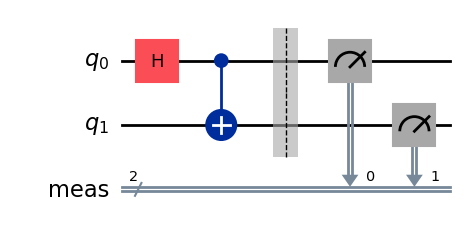

In [5]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw("mpl", style="iqp")

<Admonition type="note">
Any quantum circuit passed to a Sampler **must** include measurements.
</Admonition>

### Initialize `Sampler`

To use the Sampler V2 implementation, follow the instructions to instantiate a
[`qiskit.primitives.StatevectorSampler`](../api/qiskit/qiskit.primitives.StatevectorSampler). If you want to maintain
your pre-existing workflow using a Sampler V1 implementation, you can also use the
[`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) class.

<Tabs>
  <TabItem value="SamplerV2" label="StatevectorSampler (V2)">
    ```python
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()
```
  </TabItem>

  <TabItem value="SamplerV1" label="Sampler (V1)">
    ```python
from qiskit.primitives import Sampler

sampler = Sampler()
```
  </TabItem>
</Tabs>

### Run and get results

<Tabs>
  <TabItem value="SamplerV2" label="StatevectorSampler (V2)">
    ```python
    # execute 1 circuit with 3 parameter sets using Sampler V2
    job = sampler_v2.run([(circuit, [vals1, vals2, vals3])])
    counts = job.result()[0].data.meas.get_counts()
    ```
  V2 primitives accept multiple PUBs as inputs, and each PUB gets its own result.
  Therefore, you can run different circuits with various parameter/observable combinations,
  which was not always possible in the V1 interface:

    ```python
    # execute 2 circuits with 1 parameter set using Sampler V2
    job = sampler_v2.run([(circuit1, vals1), (circuit2, vals1)])
    counts1 = job.result()
    counts2 = job.result()
    ```
  </TabItem>

  <TabItem value="SamplerV1" label="Sampler (V1)">
      Run Sampler by calling the [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run)
    method, which returns an instance of [`qiskit.providers.JobV1`](../api/qiskit/qiskit.providers.JobV1).
    You can get the results from the job (as a [`qiskit.primitives.SamplerResult`](../api/qiskit/qiskit.primitives.SamplerResult) object)
    with the [`qiskit.providers.JobV1.result`](../api/qiskit/qiskit.providers.JobV1#result) method.

    ```python
    job = sampler.run(qc)
    result = job.result()
    print(result)
    ```

    ```python
    SamplerResult(quasi_dists=[{0: 0.4999999999999999, 3: 0.4999999999999999}], metadata=[{}])
    ```
  </TabItem>
</Tabs>

### Get the probability distribution or measurement outcome

As mentioned above, the result retrieval step is different between V1 and V2 interfaces.

The V1 sampler gives access to quasi-probability distributions.

The V2 sampler returns measurement outcome samples in the form of **bitstrings** or
**counts**. The bitstrings show the measurement outcomes, preserving the shot
order in which they were measured. The V2 sampler result objects organize
data in terms of their input circuits' classical register names, for
compatibility with dynamic circuits.


<Tabs>
  <TabItem value="SamplerV2" label="SamplerV2">
    <Admonition> The name of the classical register defaults to `"meas"`.
    This name will be used later to access the measurement bitstrings.</Admonition>

      ```python
    # Define quantum circuit with 2 qubits
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.measure_all()
    circuit.draw()
    ```
    ```python
    # Run using V2 sampler
    result = sampler_v2.run([circuit]).result()
    # Access result data for PUB 0
    data_pub = result[0].data
    # Access bitstring for the classical register "meas"
    bitstring = data_pub.meas.get_bitstring()
    print(f"The bitstring shape is: {bitstring.shape}")
    # Get counts for the classical register "meas"
    counts = data_pub.meas.get_counts()
    print(f"The counts are: {counts}")
    ```
    ```text
    The bitstring shape is: (1024, 1)
    The counts are: {'00': 523, '11': 501}
    ```
  </TabItem>

  <TabItem value="SamplerV1" label="Sampler (V1)">

<Admonition type="note">
A quasi-probability distribution differs from a probability distribution in that negative values are also allowed.
However, the quasi-probabilities must sum up to 1 like probabilities.
Negative quasi-probabilities may appear when using error mitigation techniques.
</Admonition>
    ```python
    # Define quantum circuit with 2 qubits
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.measure_all()
    circuit.draw()
    ```

    ```python
    # Run using V1 sampler
    result = sampler_v1.run(circuit).result()
    quasi_dist = result.quasi_dists[0]
    print(f"The quasi-probability distribution is: {quasi_dist}")
    ```
    ```text
    The quasi-probability distribution is: {0: 0.5, 3: 0.5}
    ```

      If you prefer to see the output keys as binary strings instead of decimal numbers, you can use the [`qiskit.result.QuasiDistribution.binary_probabilities`](../api/qiskit/qiskit.result.QuasiDistribution#binary_probabilities) method.

    ```python
    print(quasi_dist.binary_probabilities())
    ```

    ```python
    {'00': 0.4999999999999999, '11': 0.4999999999999999}
    ```

  </TabItem>
</Tabs>

### Change run options

By default, the reference Sampler performs an exact statevector calculation based on the
[`quantum_info.Statevector`](../api/qiskit/qiskit.quantum_info.Statevector) class.
However, this can be modified to introduce the effect of the sampling overhead (also known as "shot noise").

With the introduction of the new V2 interface, the sampling overhead in the Sampler is now more precisely defined.
The new interface accepts a `shots` argument that can be defined at the "PUB level".

<Tabs>
  <TabItem value="V2" label="StatevectorSampler (V2)">

    ```python
    # Sample two circuits at 128 shots each.
    sampler_v2.run([circuit1, circuit2], shots=128)
    # Sample two circuits at different amounts of shots. The "None"s are necessary
    # as placeholders
    # for the lack of parameter values in this example.
    sampler_v2.run([(circuit1, None, 123), (circuit2, None, 456)])
    ```

  </TabItem>

  <TabItem value="V1" label="Sampler (V1)">

      The V1 interface specifies shots in the following ways:

        - Setting keyword arguments in the [`Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run) method.
        - Modifying the [`Sampler`](../api/qiskit/qiskit.primitives.Sampler) options.

    ```python
    job = estimator.run(qc, observable, shots=2048, seed=123)
    result = job.result()
    print(result)
    ```
  </TabItem>
</Tabs>

## Next steps

<Admonition type="tip" title="Recommendations">
  - For higher-performance simulation that can handle larger circuits, or to incorporate noise models into your simulation, see [Exact and noisy simulation with Qiskit Aer primitives](simulate-with-qiskit-aer).
  - To learn how to use Quantum Composer for simulation, try the [Explore gates and circuits with the Quantum Composer](https://learning.quantum.ibm.com/tutorial/explore-gates-and-circuits-with-the-quantum-composer) tutorial.
  - Read the [Qiskit Estimator API](/api/qiskit/qiskit.primitives.Estimator) reference.
  - Read the [Qiskit Sampler API](/api/qiskit/qiskit.primitives.Sampler) reference.
  - Learn how to run on a physical system in the [Run](../run) section.
</Admonition>